The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


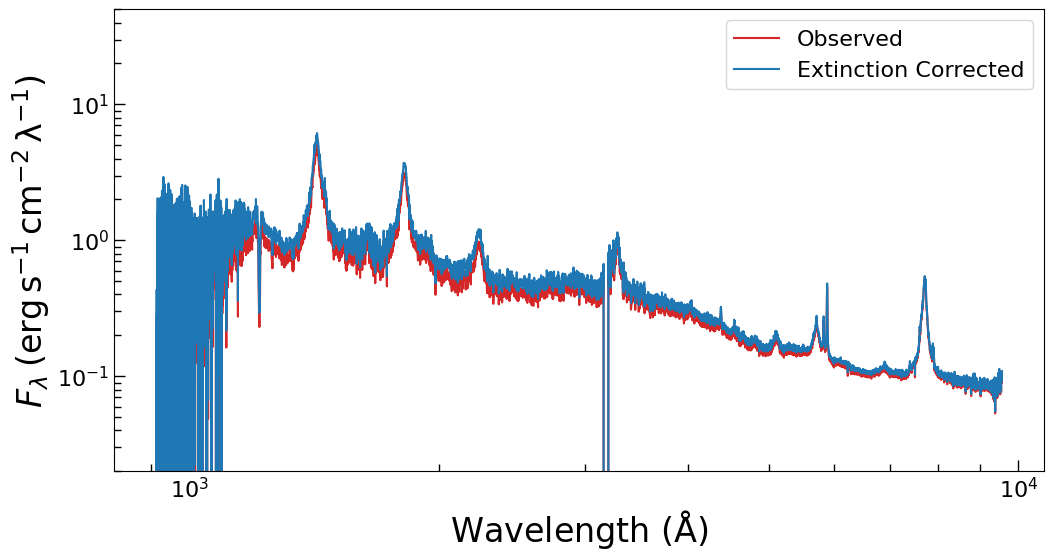

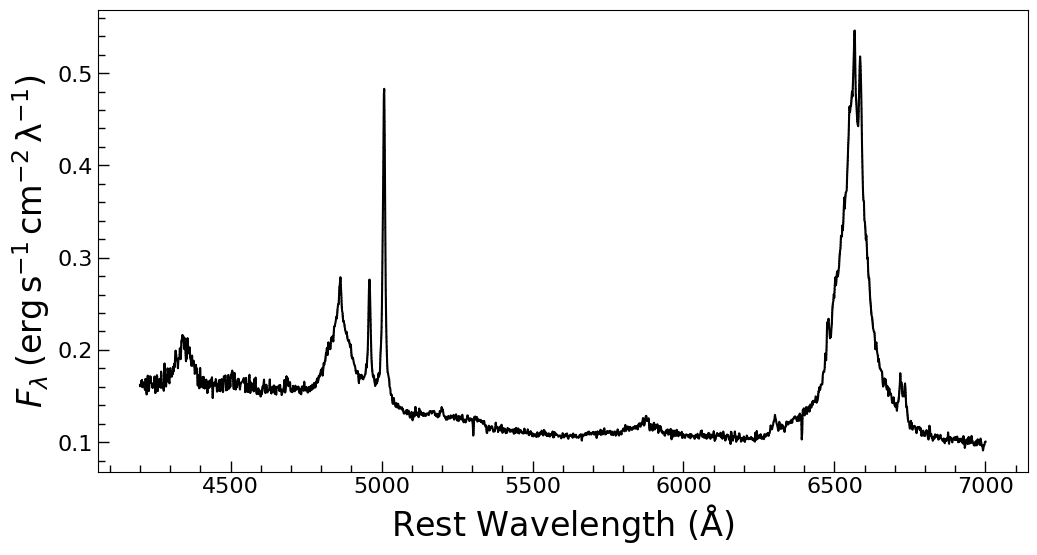

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg2349sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.075    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.1740 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

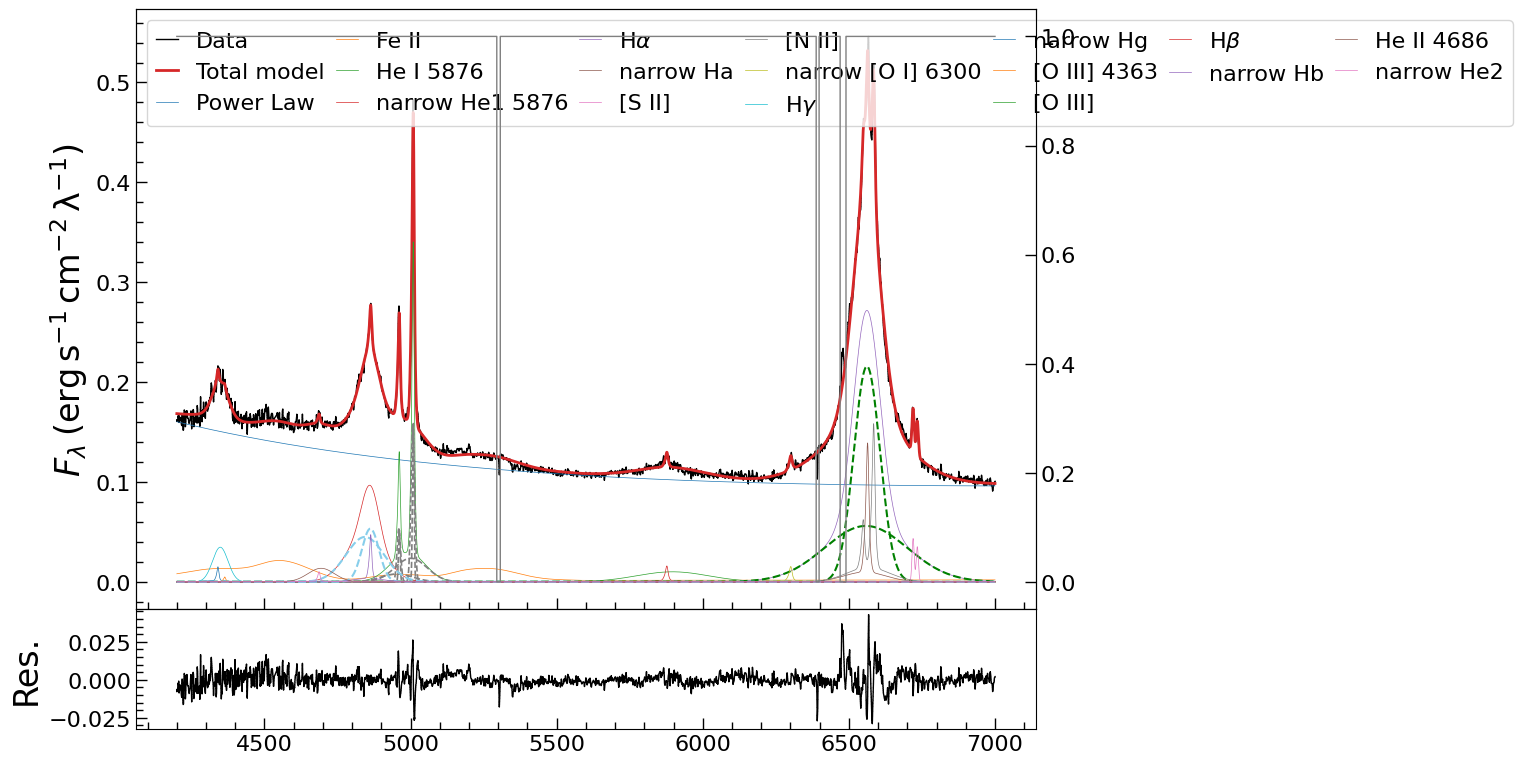

<PowerLaw1D(amplitude=0.0955266, x_0=5500., alpha=1.73025, name='Power Law')>
<IronTemplate(amplitude=0.0339, stddev=4109.34, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.00836111, dv_c=930.60926506, sigma_c=6260.25495839, wavec=5875.624, name='He I 5876')>
<Line_MultiGauss(amp_c=0.0062656, dv_c=61.24665274, sigma_c=167.10743665, wavec=5876., amp_w0=1., dv_w0=-99.56671396, sigma_w0=372.87550524, amp_w1=0.14940874, dv_w1=-500., sigma_w1=3276.55514981, name='narrow He1 5876')>
<Line_MultiGauss(amp_c=0.1565993, dv_c=-74.76529512, sigma_c=2049.00000628, wavec=6562.819, amp_w0=0.25992594, dv_w0=-344.22563243, sigma_w0=6478.46315618, name='H$\\alpha$')>
<Line_MultiGauss(amp_c=0.04762275, dv_c=61.24665274, sigma_c=167.10743665, wavec=6562.819, amp_w0=1., dv_w0=-99.56671396, sigma_w0=372.87550524, amp_w1=0.14940874, dv_w1=-500., sigma_w1=3276.55514981, name='narrow Ha')>
<Line_MultiGauss_doublet(amp_c0=0.03037492, amp_c1=0.02454438, dv_c=61.24665274, sigma_c=167.10743665, wavec0=6718.29, wave

In [7]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
poly = models.Polynomial1D(degree=2, name='multi')  
#fixed={'x_0': True,'amplitude':True,'alpha':True},fixed={'amplitude':True,'stddev':True}
pl = models.PowerLaw1D(amplitude=0.0955266, x_0=5500, alpha=1.73025, fixed={'x_0': True,'amplitude':True,'alpha':True},name='Power Law')
iron = sagan.IronTemplate(amplitude=0.0339, stddev=4109.34, z=0,fixed={'amplitude':True,'stddev':True}, name='Fe II')

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.229, dv_c=-96, sigma_c=2070, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.289, dv_w0=-140, sigma_w0=5556)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.0427, dv_c=462, sigma_c=2234, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.044, dv_c=-23.66, sigma_c=1567, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=1.34, dv_w0=-132, sigma_w0=3000, bounds=bounds)

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.013, dv_c=-190, sigma_c=2539, wavec=5875.624, name='He I 5876')
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.038, amp_c1=0.032,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
line_n2 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.15, amp_c1=0.05, dv_c=107, sigma_c=220,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')
##line_o3 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.32, amp_c1=0.1, dv_c=-10, sigma_c=350, 
##                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]')
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500), 'dv_w0': (-500, 500), 'dv_w1': (-500, 500),
          'sigma_w0': (100, 4000), 'sigma_w1': (100, 4000)}
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.2945, amp_c1=0.098, dv_c=-1.26, sigma_c=140, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.13, dv_w0=9, sigma_w0=208,
                                        amp_w1=0.05, dv_w1=-9, sigma_w1=2208,bounds=bounds)
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01156, dv_c=500, sigma_c=2580, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie functions
def tie_narrow_sigma_c(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv_c(model):
    return model['[O III]'].dv_c

def tie_narrow_sigma_w0(model):
    return model['[O III]'].sigma_w0

def tie_narrow_dv_w0(model):
    return model['[O III]'].dv_w0

def tie_narrow_amp_w0(model):
    return model['[O III]'].amp_w0

def tie_narrow_sigma_w1(model):
    return model['[O III]'].sigma_w1

def tie_narrow_dv_w1(model):
    return model['[O III]'].dv_w1

def tie_narrow_amp_w1(model):
    return model['[O III]'].amp_w1

line_s2.sigma_c.tied = tie_narrow_sigma_c
line_s2.dv_c.tied = tie_narrow_dv_c
line_n2.sigma_c.tied = tie_narrow_sigma_c
line_n2.dv_c.tied = tie_narrow_dv_c
line_n2.sigma_w0.tied = tie_narrow_sigma_w0
line_n2.dv_w0.tied = tie_narrow_dv_w0
line_n2.amp_w0.tied = tie_narrow_amp_w0
line_n2.sigma_w1.tied = tie_narrow_sigma_w1
line_n2.dv_w1.tied = tie_narrow_dv_w1
line_n2.amp_w1.tied = tie_narrow_amp_w1

n_hb = sagan.Line_MultiGauss(n_components=3, amp_c=0.086, dv_c=0, sigma_c=200, wavec=wave_dict['Hbeta'], name=f'narrow Hb', amp_w0=0.086, dv_w0=0, sigma_w0=200)
n_hg = sagan.Line_MultiGauss(n_components=3, amp_c=0.02, dv_c=0, sigma_c=200, wavec=4340, name=f'narrow Hg', amp_w0=0.02, dv_w0=0, sigma_w0=200)
n_he2 = sagan.Line_MultiGauss(n_components=3, amp_c=0.029, dv_c=0, sigma_c=200, wavec=wave_dict['HeII_4686'], name=f'narrow He2', amp_w0=0.029, dv_w0=0, sigma_w0=200)
n_o3_4363 = sagan.Line_MultiGauss(n_components=3, amp_c=0.0056, dv_c=0, sigma_c=200, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363', amp_w0=0.0056, dv_w0=0, sigma_w0=200)
n_ha = sagan.Line_MultiGauss(n_components=3, amp_c=0.16, dv_c=0, sigma_c=200, wavec=wave_dict['Halpha'], name=f'narrow Ha', amp_w0=0.16, dv_w0=0, sigma_w0=200)
n_o1_6300= sagan.Line_MultiGauss(n_components=3, amp_c=0.016, dv_c=0, sigma_c=200, wavec=6300, name=f'narrow [O I] 6300', amp_w0=0.016, dv_w0=0, sigma_w0=200)
n_he1_5876 = sagan.Line_MultiGauss(n_components=3, amp_c=0.0094, dv_c=0, sigma_c=200, wavec=5876, name=f'narrow He1 5876', amp_w0=0.0094, dv_w0=0, sigma_w0=200)

line_he1 =  b_he1 + n_he1_5876
line_ha  =  b_ha + n_ha
line_hg  =  b_hg + n_hg
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2

m_init = (pl+iron+line_he1+ line_ha+ line_s2 +line_n2+n_o1_6300 + line_hg+ n_o3_4363+line_o3+line_hb+line_he2)*poly

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_o1_6300,n_he1_5876]:
    line.sigma_c.tied = tie_narrow_sigma_c
    line.dv_c.tied = tie_narrow_dv_c
    line.sigma_w0.tied = tie_narrow_sigma_w0
    line.dv_w0.tied = tie_narrow_dv_w0
    line.amp_w0.tied = tie_narrow_amp_w0
    line.sigma_w1.tied = tie_narrow_sigma_w1
    line.dv_w1.tied = tie_narrow_dv_w1
    line.amp_w1.tied = tie_narrow_amp_w1

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 5295) & (wave_use < 5307)
fltr2= (wave_use > 6388) & (wave_use < 6398)
fltr3=(wave_use > 6470) & (wave_use < 6490)
fltr11=(wave_use > 4260) & (wave_use < 4430)
fltr12=(wave_use > 4600) & (wave_use < 5120)
fltr13=(wave_use > 5550) & (wave_use < 6050)
fltr14=(wave_use > 6200) & (wave_use < 6890)
fltr15=(wave_use > 7010) & (wave_use < 7500)

weights[fltr1] = 0.0
weights[fltr2] = 0.0
weights[fltr3] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0
#weights[fltr15] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

### plot a picture

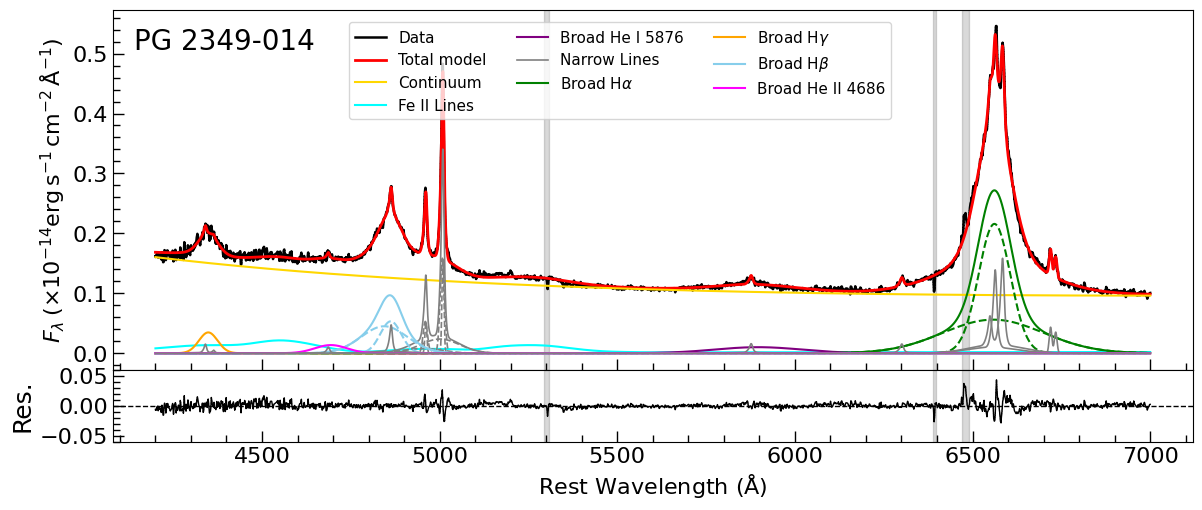

In [8]:
import matplotlib.pyplot as plt
from sagan.plot import plot_fit
ax, axr = plot_fit(wave_use, flux_use, m_fit)#weight=weights
fig = plt.gcf()
fig.set_size_inches(10*1.2, 4*1.2)  # 例如，宽度为10*1.2，高度为4*1.2
ax.set_ylabel(r'$F_\lambda\:(\times 10^{-14}\mathrm{erg\,s^{-1}\,cm^{-2}\,\AA^{-1}})$', fontsize=16)
ax.set_xlim(4200, 7000)
axr.set_xlim(4080, 7120)
axr.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=16)
axr.set_ylabel(r'Res.', fontsize=18)
axr.set_ylim(-0.06,0.06)
axr.axhline(0, color='black', linestyle='--', linewidth=1.0)
legend_kwargs = {'loc': 'center', 'bbox_to_anchor': (0.47, 0.83), 'ncol': 3, 'fontsize': 11}#-------修改legend位置
###data和totl model宽度设为1.8，窄线宽度设为1.2，主要宽线和连续谱设为1.5
for line in ax.get_lines():# 修改 Data 线的粗细
    if line.get_label() == 'Data' or line.get_label() == 'Total Model':
        line.set_linewidth(1.8)  
    if line.get_label() == 'Total model':
        line.set_color('red')  # 设置 Total Model 线的颜色为鲜红色
    #设置几个主要宽线Ha,Hb,Hg,HeI5876,HeII4686的粗细
    if line.get_label() == r'H$\alpha$' or line.get_label() == r'H$\beta$' or line.get_label() == r'H$\gamma$' or line.get_label() == 'He I 5876' or line.get_label() == 'He II 4686':
        line.set_linewidth(1.5)
ax.legend(**legend_kwargs)

for line in ax.get_lines():#设置power law的颜色为深黄色,宽度为1.5和名字为'Continuum'
    if line.get_label() == 'Power Law':
        line.set_linewidth(1.5)
        line.set_label('Continuum')
        line.set_color('gold')
for line in ax.get_lines():#设置Fe II的颜色为青
    if line.get_label() == 'Fe II':
        line.set_label('Fe II Lines')
        line.set_linewidth(1.5)
        line.set_color('cyan')

for line in ax.get_lines():
    if line.get_label() == r'H$\alpha$':#设置Halpha宽线的颜色为深绿色
        line.set_color('green')
        line.set_label('Broad H$\\alpha$')
    if line.get_label() == r'H$\beta$':#设置Hbeta宽线的颜色为浅蓝色
        line.set_color('skyblue')
        line.set_label('Broad H$\\beta$')
    if line.get_label() == r'H$\gamma$':#设置Hgamma宽线的颜色为深橙色
        line.set_color('orange')
        line.set_label('Broad H$\\gamma$')
    if line.get_label() == 'He I 5876':#设置HeI5876宽线的颜色为紫色
        line.set_color('purple')
        line.set_label('Broad He I 5876')
    if line.get_label() == 'He II 4686':#设置HeII4686宽线的颜色为深粉色
        line.set_color('magenta')
        line.set_label('Broad He II 4686')

#另外的宽线成分，记得具体调整
other_broad_lines_labels=[]
colors = ['darkgoldenrod','lightcoral', 'steelblue', 'peachpuff', 'mistyrose']
i_color_index=-1
for line in ax.get_lines():
    if line.get_label() in other_broad_lines_labels:
        i_color_index+=1
        line.set_linewidth(1.5)
        line.set_color(colors[i_color_index])
        line.set_label('Broad ' +line.get_label())

# 设置窄线的颜色为灰色，并合并为一类图例 "Narrow Lines"，记得具体调整窄线成分
narrow_lines_labels = ['narrow Ha', 'narrow Hb', 'narrow Hg', '[O III] 4363','[O III]','narrow He2','narrow [O I] 6300','narrow He1 5876','[N II]',"[S II]"]
for line in ax.get_lines():
    if line.get_label() in narrow_lines_labels:
        line.set_color('gray')
        line.set_label('Narrow Lines')
        line.set_linewidth(1.2)
# 移除重复的 "Narrow Lines" 图例
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), **legend_kwargs)

# 填充 weights=0 的区域
zero_weight_regions = np.where(weights == 0)[0]
if len(zero_weight_regions) > 0:
    for region in np.split(zero_weight_regions, np.where(np.diff(zero_weight_regions) != 1)[0] + 1):
        ax.axvspan(wave_use[region[0]], wave_use[region[-1]], color='black', alpha=0.15)
        axr.axvspan(wave_use[region[0]], wave_use[region[-1]], color='black', alpha=0.15)

# 在图的左上角标记 '3C273'
ax.text(0.02, 0.95, 'PG 2349-014', transform=ax.transAxes, fontsize=20, verticalalignment='top')

plt.show()

### Measure the errors
* $F_{\text{err}} = \sqrt{(\text{RMS}_{\text{running}})^2 + (0.05 F_\lambda)^2}$

[0.00811293 0.0080975  0.00808205 ... 0.00502559 0.00503103 0.00503648]


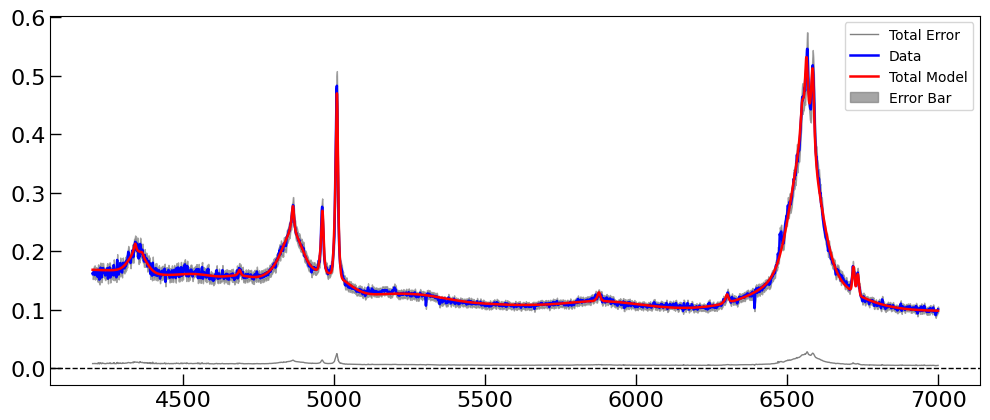

In [9]:
import sys
import os
# 获取当前工作目录的父目录
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# 将父目录添加到 sys.path
sys.path.append(parent_dir)
from error_calculation import calculate_total_error
import numpy as np

#----------------------------赋值，四个parameters----------------------------
wave_use = [i for i in wave_use if 4200 <= i <= 7000]
flux_use = flux_use[:len(wave_use)]
m_fit = m_fit
weights = weights[:len(wave_use)]

# 计算总误差
F_err = calculate_total_error(wave_use, flux_use, m_fit, weights)

# 打印结果以验证
print(F_err)
#add error bar to the flux data
plt.figure(figsize=(12, 4.8))
plt.plot(wave_use, F_err, label='Total Error', color='gray', linewidth=1, alpha=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.plot(wave_use, flux_use, label='Data', color='blue', linewidth=1.8)
plt.plot(wave_use, m_fit(wave_use), label='Total Model', color='red', linewidth=1.8)
plt.fill_between(wave_use, flux_use - F_err, flux_use + F_err, color='gray', alpha=0.7, label='Error Bar')
plt.legend()
plt.show()

### Measure the paremeters

* calculate broad line width (km/s) at different height 

In [10]:
from width_measuring import calculate_broad_line_widths
print(calculate_broad_line_widths(wave_use, m_fit))

{'Halpha': {'FWQM_1_4': 8657.670315353807, 'FWHM': 5596.072230346586, 'FWQM_3_4': 3497.3020056180703}, 'Hbeta': {'FWQM_1_4': 9663.186048390446, 'FWHM': 5917.0935487834995, 'FWQM_3_4': 3570.2072876422317}}


* calculate $v_{peak}$ and A.I.(asymmetry index) and K.I.(Kurtosis Index)

In [11]:
from AI_and_KIcalculation import calculate_AI_KI_and_vpeak
print(calculate_AI_KI_and_vpeak(wave_use, m_fit))

{'Halpha': {'v_peak': 61.246652739464764, 'A.I.': -0.0663644251913818, 'K.I.': 0.4039541676027829}, 'Hbeta': {'v_peak': 61.246652739464764, 'A.I.': -0.17511134608334034, 'K.I.': 0.3694648193425713}}


* $\text{Equivalent Width}\text{(EW,\AA)} = \int_{{\lambda}_1}^{{\lambda}_2} \frac{F_{\lambda,\text{model}}}{\text{Power Law}_{\text{model}}} \,d\lambda$
* measure the EW and integrated flux of $Broad H\alpha,H\beta$, $Narrow H\alpha,H\beta$, $Narrow [O III]$ and ${{FeII}}_{4434,4684\AA}$

In [12]:
from EW_and_IntegratedFlux_calcul import calculate_equivalent_widths_and_integrated_fluxes
print(calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit))

{'EW': {'b_Ha': 455.1322571820649, 'b_Hb': 89.04976625175298, 'n_Ha': 38.188226275240964, 'n_Hb': 7.422627669398564, 'n_OIII': 75.05015808682572, 'FeII': 31.31304736034361}, 'integrated_flux': {'b_Ha': 44.17320576867997, 'b_Hb': 11.236961732102994, 'n_Ha': 3.7052504215915922, 'n_Hb': 0.9340635099768827, 'n_OIII': 9.09432464378324, 'FeII': 15.80051498532984}}


* Measure $L_{5100}(\mathrm{erg\,s^{-1}\,\AA^{-1})}$, $L_{5100}=4\pi {D_L}^{2} f_{\lambda}(5100\AA)$

In [13]:
from L5100_calculation import calculate_L5100
print(calculate_L5100(zred, m_fit, wave_use))

1.1636215170386438e+55


* Measure $\sigma_{line}$ (km/s)  ------ it is the $\sigma_{v}$?
* obey the equation: $[ \sigma_{\text{line}} = \sqrt{\frac{\int (\lambda - \lambda_0)^2 f(\lambda) \, d\lambda}{\int f(\lambda) \, d\lambda}} = \frac{{\lambda}_0}{c} {\sigma}_v]$

${\sigma}_v=\sqrt{\frac{\int v^2 f(v) \, dv}{\int f(v) \, dv}}$

In [14]:
from sigma_line_calculation import calculate_broad_line_sigma
print(calculate_broad_line_sigma(m_fit,wave_use))


{'sigma_line_Ha': 4593.094496793269, 'sigma_line_Hb': 3539.29623339518}


### Measure the parameter uncertainties

* alter the masked regions use model data

In [15]:
# 获取拟合的总模型
total_model = m_fit(wave_use)

# 替换被 mask 掉的区域数据
flux_use_replaced = np.copy(flux_use)
mask = (weights == 0.0)
flux_use_replaced[mask] = total_model[mask]


* generate 100 mock spectra

In [16]:
#生成100个mock光谱
mock_spectra = [np.copy(flux_use_replaced) for _ in range(100)]
# generate random noise use the F_err
for i in range(len(flux_use_replaced)):
    random_numbers = np.random.normal(loc=0, scale=F_err[i], size=len(mock_spectra))
    for j in range(len(mock_spectra)):
        mock_spectra[j][i] += random_numbers[j]

* fit the 100 mock spectra, and then store the m_fit in m_fit_lst

In [17]:
from spectral_fit import fit_pg2349

#store the fitting results model in m_fit_lst
m_fit_lst=[]
m_fit_lst.append(m_fit)
for i in range(len(mock_spectra)):
    m_fit_lst.append(fit_pg2349(wave_use, mock_spectra[i]))

* calculate and store the parameters of 100 mock spectra, then calculate the uncertainties

In [20]:
# 定义要写入的标题
header = 'Ha_FWQM_1_4 Ha_FWHM Ha_FWQM_3_4 Hb_FWQM_1_4 Hb_FWHM Hb_FWQM_3_4 EW_b_Ha EW_b_Hb EW_n_Ha EW_n_Hb EW_n_OIII EW_FeII integrated_flux_b_Ha integrated_flux_b_Hb integrated_flux_n_Ha integrated_flux_n_Hb integrated_flux_n_OIII integrated_flux_FeII L5100 sigma_line_Ha sigma_line_Hb v_peak A.I._Ha K.I._Ha A.I._Hb K.I._Hb'
# 文件路径
file_path = 'results/results.txt'
# 打开文件并写入内容
with open(file_path, 'w') as file:
    # 写入标题行
    file.write(header + '\n')
    # 写入每一行的值
    for i in range(len(m_fit_lst)):
        m_fit = m_fit_lst[i]
        Ha_FWQM_1_4 = calculate_broad_line_widths(wave_use, m_fit)['Halpha']['FWQM_1_4']
        Ha_FWHM = calculate_broad_line_widths(wave_use, m_fit)['Halpha']['FWHM']
        Ha_FWQM_3_4 = calculate_broad_line_widths(wave_use, m_fit)['Halpha']['FWQM_3_4']
        Hb_FWQM_1_4 = calculate_broad_line_widths(wave_use, m_fit)['Hbeta']['FWQM_1_4']
        Hb_FWHM = calculate_broad_line_widths(wave_use, m_fit)['Hbeta']['FWHM']
        Hb_FWQM_3_4 = calculate_broad_line_widths(wave_use, m_fit)['Hbeta']['FWQM_3_4']
        EW_b_Ha = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['b_Ha']
        EW_b_Hb = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['b_Hb']
        EW_n_Ha = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['n_Ha']
        EW_n_Hb = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['n_Hb']
        EW_n_OIII = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['n_OIII']
        EW_FeII = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['EW']['FeII']
        integrated_flux_b_Ha = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['b_Ha']
        integrated_flux_b_Hb = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['b_Hb']
        integrated_flux_n_Ha = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['n_Ha']
        integrated_flux_n_Hb = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['n_Hb']
        integrated_flux_n_OIII = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['n_OIII']
        integrated_flux_FeII = calculate_equivalent_widths_and_integrated_fluxes(wave_use, m_fit)['integrated_flux']['FeII']
        L5100 = calculate_L5100(zred, m_fit, wave_use)
        sigma_line_Ha = calculate_broad_line_sigma(m_fit, wave_use)['sigma_line_Ha']
        sigma_line_Hb = calculate_broad_line_sigma(m_fit, wave_use)['sigma_line_Hb']
        v_peak = calculate_AI_KI_and_vpeak(wave_use, m_fit)['Halpha']['v_peak']
        AI_Ha = calculate_AI_KI_and_vpeak(wave_use, m_fit)['Halpha']['A.I.']
        KI_Ha = calculate_AI_KI_and_vpeak(wave_use, m_fit)['Halpha']['K.I.']
        AI_Hb = calculate_AI_KI_and_vpeak(wave_use, m_fit)['Hbeta']['A.I.']
        KI_Hb = calculate_AI_KI_and_vpeak(wave_use, m_fit)['Hbeta']['K.I.']

        # 将所有参数组合成一行
        line = f"{Ha_FWQM_1_4} {Ha_FWHM} {Ha_FWQM_3_4} {Hb_FWQM_1_4} {Hb_FWHM} {Hb_FWQM_3_4} {EW_b_Ha} {EW_b_Hb} {EW_n_Ha} {EW_n_Hb} {EW_n_OIII} {EW_FeII} {integrated_flux_b_Ha} {integrated_flux_b_Hb} {integrated_flux_n_Ha} {integrated_flux_n_Hb} {integrated_flux_n_OIII} {integrated_flux_FeII} {L5100} {sigma_line_Ha} {sigma_line_Hb} {v_peak} {AI_Ha} {KI_Ha} {AI_Hb} {KI_Hb}"
        # 写入文件
        file.write(line + '\n')


In [21]:
import numpy as np

# 文件路径
file_path = 'results/results.txt'
uncertainties_file_path = 'results/uncertainties.txt'

# 读取文件内容
with open(file_path, 'r') as file:
    lines = file.readlines()

# 提取标题行和数据行
header = lines[0].strip().split()
data_lines = lines[1:]

# 将数据行转换为二维列表
data = [list(map(float, line.strip().split())) for line in data_lines]

# 将数据转换为字典，键为标题，值为对应列的数据
data_dict = {key: [] for key in header}
for row in data:
    for key, value in zip(header, row):
        data_dict[key].append(value)

# 提取第一行数据作为数据
first_row_data = data[0]

# 计算每个参数的标准差（uncertainty）
uncertainties = {key: np.std(data_dict[key][1:101]) for key in header}

# 将结果写入 uncertainties.txt 文件
with open(uncertainties_file_path, 'w') as file:
    for key, value in zip(header, first_row_data):
        uncertainty = uncertainties[key]
        line = f"{key}: {value} ± {uncertainty}"
        file.write(line + '\n')

print(f"Uncertainties written to {uncertainties_file_path}")

Uncertainties written to results/uncertainties.txt


### Generate the normalized line profiles

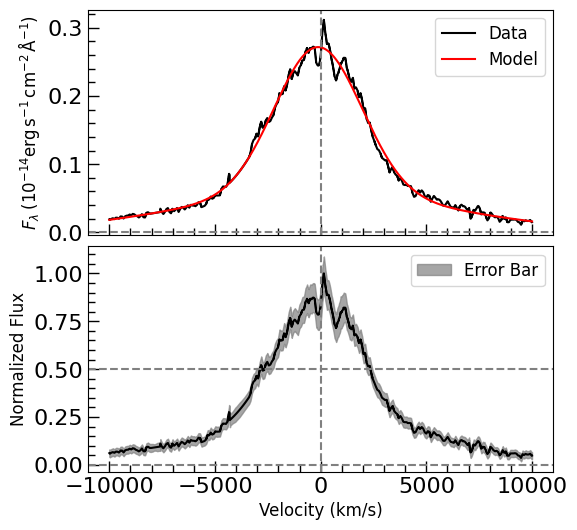

In [22]:
# ---------------------------------------------H_alpha
m_multi=m_fit['multi'](wave_use)
m_alpha=m_fit[label_dict['Halpha']](wave_use)*m_multi
flux_halpha= flux_use_replaced.copy()
#correct the wavelength so that the narrow lines have central velocity of 0 km/s
dv_sys=m_fit['[O III]'].dv_c.value
wave_corr=np.array(wave_use)*(1-dv_sys/ls_km)
velc=(wave_corr-wave_dict['Halpha'])/wave_dict['Halpha']*ls_km
# cut the line profile to -10000 to 10000 km/s
fltr=(velc>-10000)&(velc<10000)
for m in m_fit:
    if m.name in ['multi',label_dict['Halpha']]:
        continue
    flux_halpha-=m(wave_use)*m_multi

wave_ha=wave_corr[fltr]
flux_ha=flux_halpha[fltr]
model_ha=m_alpha[fltr]
ferr_ha=F_err[fltr]
flux_ha_norm=flux_ha/np.max(flux_ha)
ferr_ha_norm=ferr_ha/np.max(flux_ha)

fig,axs=plt.subplots(2,1,figsize=(6,6),sharex=True)
fig.subplots_adjust(hspace=0.05)

ax=axs[0]
ax.step(velc[fltr],flux_ha,color='k',label='Data')
ax.plot(velc[fltr],model_ha,color='r',label='Model')
ax.axvline(0,color='gray',linestyle='--')
ax.axhline(0,color='gray',linestyle='--')
ax.set_ylabel(r'$F_\lambda\:(\mathrm{10^{-14}erg\,s^{-1}\,cm^{-2}\,\AA^{-1}})$',fontsize=12)
ax.legend(fontsize=12)
ax.minorticks_on()

ax=axs[1]
ax.step(velc[fltr],flux_ha_norm,color='k')
plt.fill_between(velc[fltr], flux_ha_norm - ferr_ha_norm, flux_ha_norm + ferr_ha_norm, color='gray', alpha=0.7, label='Error Bar')
ax.axvline(0,color='gray',linestyle='--')
ax.axhline(0,color='gray',linestyle='--')
ax.axhline(0.5,color='gray',linestyle='--')
ax.set_xlabel(r'Velocity (km/s)',fontsize=12)
ax.set_ylabel('Normalized Flux',fontsize=12)
ax.legend(fontsize=12)
ax.minorticks_on()
plt.show()

data_ha=np.array([velc[fltr],flux_ha_norm,ferr_ha_norm]).T
np.savetxt('results/data_ha.txt',data_ha,fmt='%.6f')

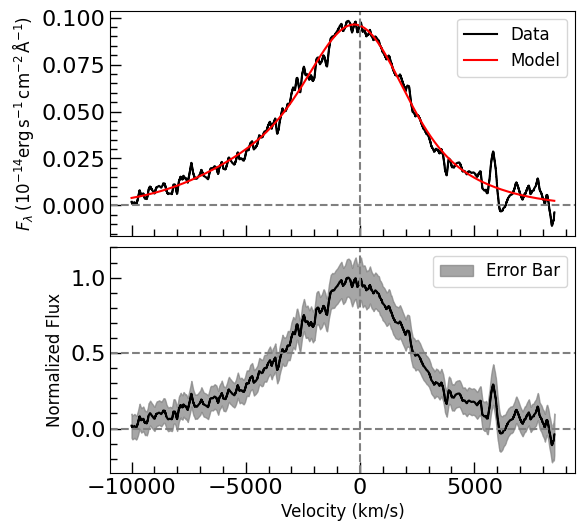

In [23]:
#---------------------------------------------H_beta
m_multi=m_fit['multi'](wave_use)
m_beta=m_fit[label_dict['Hbeta']](wave_use)*m_multi
flux_hbeta= flux_use_replaced.copy()
#correct the wavelength so that the narrow lines have central velocity of 0 km/s
dv_sys=m_fit['[O III]'].dv_c.value
wave_corr=np.array(wave_use)*(1-dv_sys/ls_km)
velc=(wave_corr-wave_dict['Hbeta'])/wave_dict['Hbeta']*ls_km
# cut the line profile to -10000 to 8500 km/s
fltr=(velc>-10000)&(velc<8500)
for m in m_fit:
    if m.name in ['multi',label_dict['Hbeta']]:
        continue
    flux_hbeta-=m(wave_use)*m_multi

wave_hb=wave_corr[fltr]
flux_hb=flux_hbeta[fltr]
model_hb=m_beta[fltr]
ferr_hb=F_err[fltr]
flux_hb_norm=flux_hb/np.max(flux_hb)
ferr_hb_norm=ferr_hb/np.max(flux_hb)

fig,axs=plt.subplots(2,1,figsize=(6,6),sharex=True)
fig.subplots_adjust(hspace=0.05)

ax=axs[0]
ax.step(velc[fltr],flux_hb,color='k',label='Data')
ax.plot(velc[fltr],model_hb,color='r',label='Model')
ax.axvline(0,color='gray',linestyle='--')
ax.axhline(0,color='gray',linestyle='--')
ax.set_ylabel(r'$F_\lambda\:(\mathrm{10^{-14}erg\,s^{-1}\,cm^{-2}\,\AA^{-1}})$',fontsize=12)
ax.legend(fontsize=12)
ax.minorticks_on()

ax=axs[1]
ax.step(velc[fltr],flux_hb_norm,color='k')
plt.fill_between(velc[fltr], flux_hb_norm - ferr_hb_norm, flux_hb_norm + ferr_hb_norm, color='gray', alpha=0.7, label='Error Bar')
ax.axvline(0,color='gray',linestyle='--')
ax.axhline(0,color='gray',linestyle='--')
ax.axhline(0.5,color='gray',linestyle='--')
ax.set_xlabel(r'Velocity (km/s)',fontsize=12)
ax.set_ylabel('Normalized Flux',fontsize=12)
ax.legend(fontsize=12)
ax.minorticks_on()
plt.show()

data_hb=np.array([velc[fltr],flux_hb_norm,ferr_hb_norm]).T  
np.savetxt('results/data_hb.txt',data_hb,fmt='%.6f')
